# CoCoRaHS Verification for Feb 2019 California Precipitation


![](https://ggweather.com/water/sf.png)
**Figure**: San Francisco 2018-2019 season rain from Golden Gate Weather (2019-04-23).

<img src="images/cocorahs-ca-2019-02-02.png" />

**Figure**: CoCoRaHS California obs for 2019-02-02.

<img src="images/cocorahs-gauge-oakland-california.jpg" />

**Figure**: CoCoRaHS gauge in Oakland.

## Create a new WinDB2
```
mike@honami:~/vscode-workspace/cocorahs-verification$ create-windb2.py localhost postgres cocorahs-california-1
```

## Mask for California only
CoCoRaHS is mostly only in the United States. So a Shapefile of the US boundaries was acquired from [here](https://www.weather.gov/gis/USStates) and used as a mask for the forecast data.

Insert the US state Shapefile into the WinDB2:
```
mike@honami:~/vscode-workspace/cocorahs-verification/data-to-import/national-weather-service$ shp2pgsql -s 4269 s_11au16.shp us_boundary_r1 | psql -U postgres cocorahs-california-1 
```
... and delete everything except California in the WinDB2:
```
cocorahs-california-1=# CREATE TABLE california_boundary_r1 AS SELECT * FROM us_boundary_r1 WHERE state='CA';

 ```

## Create a new GFS 0.25 deg domain
Created a new domain (using an arbitrary `gfs.0p25.*` file) with the `california_boundary_r1` shape as a domain mask:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ insert-gfs-file.py localhost postgres cocorahs-california-1 -n gfs.0p25.2019012818.f078.grib2 -m california_boundary_r1
```
Verified that the points looked sane by creating a map in QGIS of the WinDB2 points and the mask (note there's an [issue](https://github.com/wxmiked/windb2/issues/28) that caused some of the points to go missing.

<img src="images/ca-only-gfs-mask.png" />

Also created a backup/dump of the WinDB2 at this point to speed up development:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ pg_dump -U postgres cocorahs-california-1 > cocorahs-california-1-pgdump-empty-db-2019-04-24.sql
```
This dump can be recovered like:
```
(.venv) mike@honami:/data/gfs-forecasts/2019/hours-0-thru-72-sample$ cat cocorahs-california-1-pgdump-empty-db-2019-04-24.sql | psql -U postgres eraseme
```

## Insert all of the GFS forecasts available
From the ~90 GB of data downloaded, inserted every forecast available:
```
mike@honami:/data/gfs-forecasts/2019$ for i in `ls gfs.*`; do insert-gfs-file.py localhost postgres cocorahs-california-1 -d 1 $i; done
```

## Converting to mm/hr precip
The GFS variable for total precipitation rate is in $kg/m^2$ and the CoCoRaHS observations are in inches. Use the Pint library and the assumption that 

We need the density of water, which varies with temperature to make this calculation. From [weatherspark.com](https://weatherspark.com/m/557/2/Average-Weather-in-February-in-San-Francisco-California-United-States#Sections-Temperature), assumed the average February temperature in California was $50^o F (12.2^o C)$ based on the average San Francisco temperature. Therefore the density of water at that temperature is $.999475 g/cm^3$ according to [csgnetwork.com](http://www.csgnetwork.com/waterinformation.html).
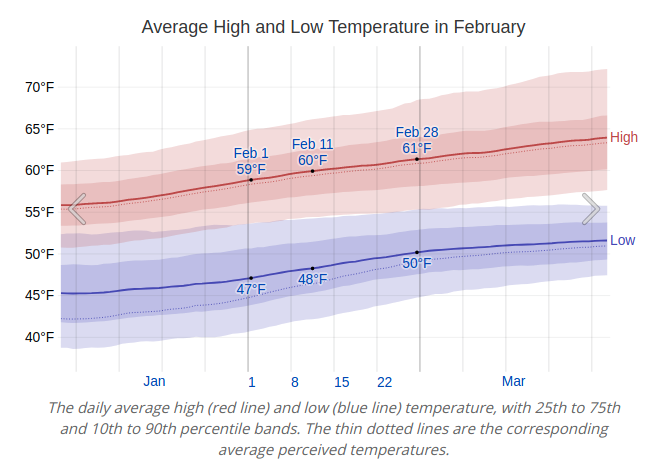

In [1]:
# Calculate the conversion between the PRATE units and inches per second for later use
import pint
ureg = pint.UnitRegistry()
prate_units = (ureg.kilogram / ureg.meter**2 / ureg.second)
h2o_density = 0.999457 * ureg.gram / ureg.centimeter**3
h2o_density.ito_base_units()
print(h2o_density)
conv_prate_to_inch_per_sec = (prate_units / h2o_density).to(ureg.inch / ureg.sec)
conv_prate_to_inch_per_sec

999.4569999999999 kilogram / meter ** 3


<Quantity(0.03939146830744843, 'inch / second')>

## Download the CoCoRaHS observations
Get all California CoCoRaHS observations for the first week of February 2019. In general, a CoCoRaHS observation is a 24 hour period starting at 7 am on the previous day and ending at 7 am on the date of the observation. The export generator for CoCoRaHS is [here](http://data.cocorahs.org/cocorahs/export/exportmanager.aspx). It should be noted that you can use `&Format=JSON` as a query parameter, even though it's not listed.

In [2]:
import requests
import json
import re
daily_report_url = 'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=3&Format=JSON&State=CA&ReportDateType=reportdate&StartDate=2/1/2019&EndDate=2/8/2019&TimesInGMT=False'
req = requests.get(url=daily_report_url)
json_fixed = re.sub(r'[\r\t\n]', '', req.text)  # remove junk chars
json_fixed = re.sub(r' :', ':', json_fixed) # remove spaces before colons
json_fixed = re.sub(r'([{,:])(\w+)([},:])', r'\1"\2"\3', json_fixed)  # regex fixes keys with missing quotes
json_fixed = re.sub(r'"([0-9]{2})"', r'\1', json_fixed)  # fix the times we broke in the last step
observations = json.loads(json_fixed)['data']['reports']

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Find the closest WinDB2 GFS forecast grid point
Load all of the CoCoRaHS station metadata and find the closest GFS forecast point to the station.

In [5]:
import sys
sys.path.append('/home/mike/vscode-workspace/windb2')
from windb2 import windb2

# Connect to the WinDB2
windb2 = windb2.WinDB2('localhost', 'cocorahs-california-1', dbUser='postgres')
windb2.connect()

# Find the closest forecast grid point to the station
stations = {}
for obs in observations:
    id = obs['st_num']
    lon = obs['lng']
    lat = obs['lat']
    
    # Get the closest geomkey to this forecast
    sql = """SELECT key, ST_Distance_Sphere(ST_GeomFromText('POINT({} {})', 4326), geom) AS dist
             FROM horizgeom 
             WHERE domainkey=1 
             ORDER BY dist 
             LIMIT 1;""".format(lon, lat)
    windb2.curs.execute(sql)
    closest_geomkey, distance_m = windb2.curs.fetchone()
    stations[id] = {'closest_geomkey': closest_geomkey, 'distance_m': distance_m}

Opening connection using dns: dbname=cocorahs-california-1 host=localhost user=postgres port=5432
Encoding for this connection is UTF8
Time zone being used for this session: UTC


## Calculate the error for each observation by forecast age

In [12]:
from datetime import datetime, timedelta
import pytz
import numpy
obs_error = []
count_thrown_out = 0
for obs in observations:
    # Ignore negative precip amounts
    if obs['totalpcpn'] < 0:
        continue
    
    station_meta = stations[obs['st_num']]
    
    # Make sure this obs is within two hours of 7 am Pacific time (15:00 UTC)
    obs_t = datetime.strptime('{}T{}'.format(obs['obs_date'], obs['obs_time']), '%Y-%m-%dT%H:%M:%S')
    obs_t = obs_t.replace(tzinfo=pytz.timezone('US/Pacific'))
    obs_t_nominal = obs_t.replace(hour=7, minute=0, second=0, microsecond=0)
    if abs((obs_t - obs_t_nominal).total_seconds()) > 2 * 3600:
        count_thrown_out += 1
        continue
    
    sql = """SELECT %s AS station_id, count(*), avg(value)*3600*24*%s AS fcst_rain_in_per_day, avg(EXTRACT(epoch FROM t - init)/3600) AS fcst_age_hr_avg
             FROM prate_1
             WHERE geomkey=%s AND t>=%s AND t<%s
             GROUP BY init 
             ORDER BY fcst_age_hr_avg;"""
    windb2.curs.execute(sql, 
                        (obs['st_num'],
                         conv_prate_to_inch_per_sec.magnitude,
                         station_meta['closest_geomkey'], 
                         obs_t_nominal, 
                         obs_t_nominal + timedelta(days=1)))
    results = windb2.curs.fetchall()
    for result in results:
        obs_error.append(result + (obs['totalpcpn'], ))

# Info
print('threw out {} ({:.1%}) obs due to time window mismatch'.format(count_thrown_out, count_thrown_out/len(obs_error)))

threw out 243 (0.7%) obs due to time window mismatch


## Exploratory data analysis

count
count    32890.000000
mean         3.492308
std          1.665263
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: count, dtype: float64

fcst_rain_in_per_day
count    32890.000000
mean         0.092953
std          0.094514
min          0.000000
25%          0.023824
50%          0.059900
75%          0.138860
max          0.721526
Name: fcst_rain_in_per_day, dtype: float64

fcst_age_hr_avg
count    32890.000000
mean       195.853846
std        113.792013
min          4.500000
25%         99.000000
50%        195.000000
75%        294.000000
max        384.000000
Name: fcst_age_hr_avg, dtype: float64

obs_precip_in_per_day
count    32890.000000
mean         0.270158
std          0.375056
min          0.000000
25%          0.000000
50%          0.040000
75%          0.520000
max          2.600000
Name: obs_precip_in_per_day, dtype: float64



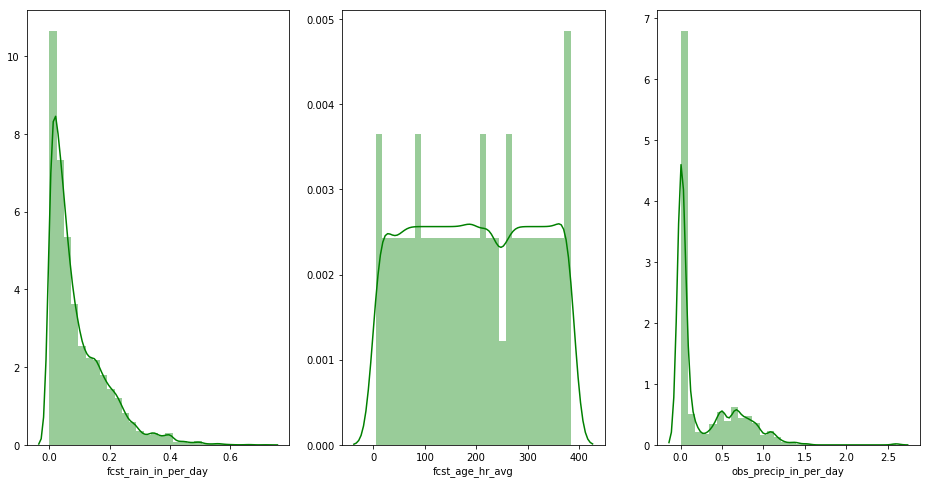

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pandas dataframe from query results
column_names = [desc[0] for desc in windb2.curs.description] + ['obs_precip_in_per_day']
df = pd.DataFrame.from_records(obs_error, columns=column_names)
fig_count = 0
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
for col_name in column_names:
    if col_name == 'station_id':
        continue
    print(col_name)
    print(df[col_name].describe())
    print()
    if col_name == 'count':
        continue
    sns.distplot(df[col_name], color='g', bins=30, hist_kws={'alpha': 0.4}, ax=axes[fig_count])
    fig_count += 1


    fcst_age_hr_avg      bias  fcst_mean  obs_mean      rmse
0               4.5 -0.193806   0.076352  0.270158  0.465198
1               7.5 -0.164334   0.105824  0.270158  0.471329
2              13.5 -0.144213   0.125945  0.270158  0.471122
3              19.5 -0.158879   0.111279  0.270158  0.468194
4              25.5 -0.157159   0.112999  0.270158  0.465677
5              31.5 -0.142693   0.127465  0.270158  0.467200
6              37.5 -0.125674   0.144484  0.270158  0.480280
7              45.0 -0.144022   0.126137  0.270158  0.470367
8              51.0 -0.165360   0.104799  0.270158  0.470224
9              57.0 -0.164152   0.106007  0.270158  0.464826
10             63.0 -0.168642   0.101516  0.270158  0.459574
11             69.0 -0.147233   0.122925  0.270158  0.473325
12             75.0 -0.164608   0.105551  0.270158  0.465935
13             81.0 -0.178246   0.091913  0.270158  0.463537
14             87.0 -0.170979   0.099180  0.270158  0.459897
15             93.0 -0.1

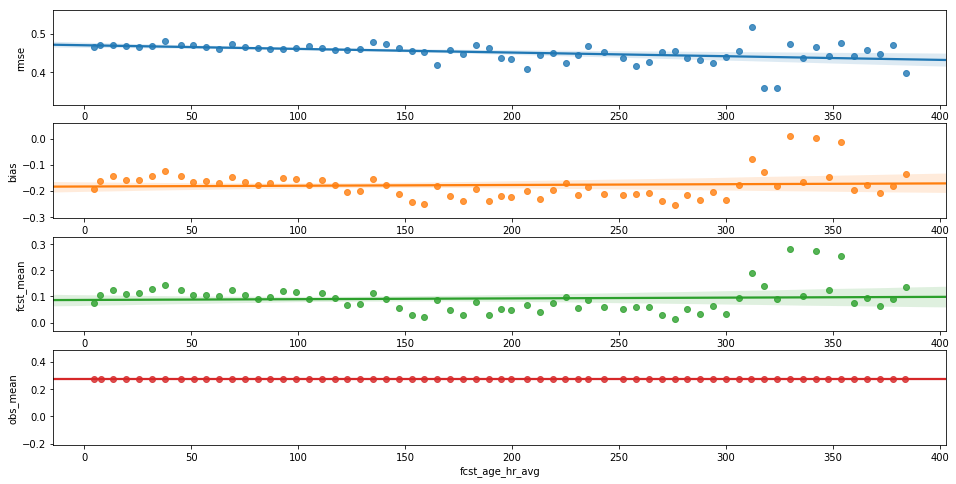

In [14]:
from sklearn.metrics import mean_squared_error
def rmse(d):
    rmse = numpy.sqrt(mean_squared_error(d['obs_precip_in_per_day'], d['fcst_rain_in_per_day']))
    bias = numpy.mean(d['fcst_rain_in_per_day'] - d['obs_precip_in_per_day'])
    fcst_mean = numpy.mean(d['fcst_rain_in_per_day'])
    obs_mean = numpy.mean(d['obs_precip_in_per_day'])
    return pd.Series(dict(rmse=rmse, bias=bias, fcst_mean=fcst_mean, obs_mean=obs_mean))

fig, ax = plt.subplots(4, 1, figsize=(16, 8))
df_groupby_age = df.groupby(['fcst_age_hr_avg']).apply(rmse).reset_index()
print(df_groupby_age)
sns.regplot(x='fcst_age_hr_avg', y='rmse', data=df_groupby_age, ax=ax[0])
sns.regplot(x='fcst_age_hr_avg', y='bias', data=df_groupby_age, ax=ax[1])
sns.regplot(x='fcst_age_hr_avg', y='fcst_mean', data=df_groupby_age, ax=ax[2])
sns.regplot(x='fcst_age_hr_avg', y='obs_mean', data=df_groupby_age, ax=ax[3])